In [2]:
import zipfile
import os

zip_path = '/content/pnevmoniya.zip'
extract_path = 'data'

with zipfile.ZipFile(zip_path, "r") as zip_ref:
  zip_ref.extractall(extract_path)

print("Successful!")

Successful!


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = datasets.ImageFolder(root='data/train', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Test dataset uchun custom class
class PneumoniaTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.images = os.listdir(test_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.test_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.images[idx]

test_dataset = PneumoniaTestDataset(test_dir='data/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
model = PneumoniaCNN().to(device)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PneumoniaCNN().to(device)

In [10]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=15):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = torch.sigmoid(outputs) >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

    return train_losses, train_accuracies

In [12]:
epochs = 15
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, epochs)

Epoch 1/15 - Loss: 0.3220 - Accuracy: 0.8748
Epoch 2/15 - Loss: 0.1349 - Accuracy: 0.9511
Epoch 3/15 - Loss: 0.1271 - Accuracy: 0.9532
Epoch 4/15 - Loss: 0.1194 - Accuracy: 0.9544
Epoch 5/15 - Loss: 0.1122 - Accuracy: 0.9594
Epoch 6/15 - Loss: 0.1001 - Accuracy: 0.9620
Epoch 7/15 - Loss: 0.0915 - Accuracy: 0.9668
Epoch 8/15 - Loss: 0.0812 - Accuracy: 0.9697
Epoch 9/15 - Loss: 0.0825 - Accuracy: 0.9686
Epoch 10/15 - Loss: 0.0795 - Accuracy: 0.9728
Epoch 11/15 - Loss: 0.0712 - Accuracy: 0.9747
Epoch 12/15 - Loss: 0.0736 - Accuracy: 0.9709
Epoch 13/15 - Loss: 0.0686 - Accuracy: 0.9745
Epoch 14/15 - Loss: 0.0641 - Accuracy: 0.9741
Epoch 15/15 - Loss: 0.0579 - Accuracy: 0.9787


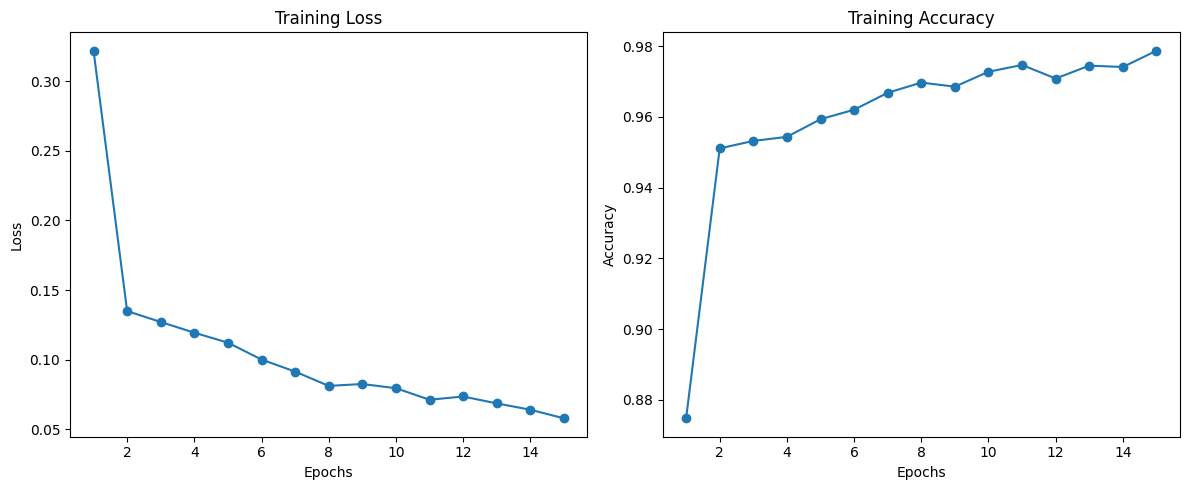

In [13]:
def plot_metrics(losses, accuracies):
    epochs_range = range(1, len(losses)+1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracies, marker='o')
    plt.title("Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, train_accuracies)

In [14]:
def evaluate_model(model, test_loader, device):
    model.eval()
    preds = []
    filenames = []

    with torch.no_grad():
        for inputs, names in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs) >= 0.5
            preds.extend(predictions.cpu().numpy())
            filenames.extend(names)

    return preds, filenames

In [16]:
preds, filenames = evaluate_model(model, test_loader, device)

# Example: ko'rsatish
for name, pred in zip(filenames[:10], preds[:10]):
    label = "PNEUMONIA" if pred else "NORMAL"
    print(f"Image: {name} → Predicted: {label}")

Image: test_img_10471.jpeg → Predicted: PNEUMONIA
Image: test_img_10233.jpeg → Predicted: NORMAL
Image: test_img_10309.jpeg → Predicted: PNEUMONIA
Image: test_img_10610.jpeg → Predicted: NORMAL
Image: test_img_10295.jpeg → Predicted: PNEUMONIA
Image: test_img_10501.jpeg → Predicted: PNEUMONIA
Image: test_img_10443.jpeg → Predicted: NORMAL
Image: test_img_10292.jpeg → Predicted: PNEUMONIA
Image: test_img_10466.jpeg → Predicted: PNEUMONIA
Image: test_img_10262.jpeg → Predicted: PNEUMONIA


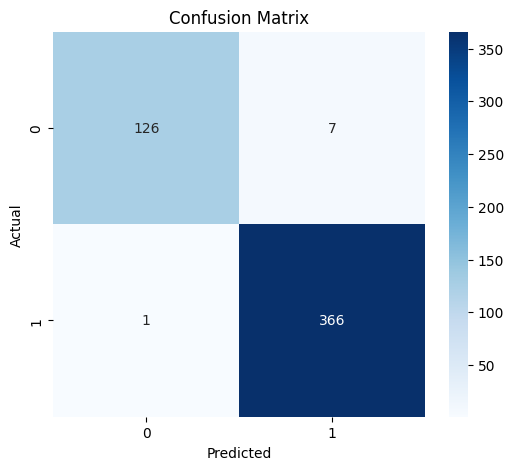

              precision    recall  f1-score   support

      NORMAL       0.99      0.95      0.97       133
   PNEUMONIA       0.98      1.00      0.99       367

    accuracy                           0.98       500
   macro avg       0.99      0.97      0.98       500
weighted avg       0.98      0.98      0.98       500



In [18]:
# Note: Agar test dataset ground truth label'lar mavjud bo'lsa, real y_true bilan solishtiriladi.
# Aks holda - faqat predictlar ko'rsatiladi.

# Agar test setda label bo'lmasa, train_loader dan kichik validation set ajratib ko'rsatish mumkin
# Hozir biz train loader'ning kichik qismini test qilamiz:
import seaborn as sns


val_size = 500
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Evaluate on validation set
def validate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs) >= 0.5
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = validate_model(model, val_loader, device)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

In [19]:
torch.save(model.state_dict(), "pneumonia_cnn_torch.pth")

In [ ]:
model.load_state_dict(torch.load("pneumonia_cnn_torch.pth"))
model.eval()